# Time dependent boundary condition

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi, Piecewise, sin, Matrix

from library.fvm.solver import HyperbolicSolver
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted, Legendre_DN, Chebyshevt_shifted
from library.model.models.basismatrices import Basismatrices
from library.model.models.shallow_moments import ShallowMoments
import library.misc.io as io

import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper

from library.misc.misc import Zstruct, Settings


import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse
from library.model.models.basisfunctions import Legendre_shifted, Basisfunction
from library.model.models.basismatrices import Basismatrices


## Model

In [2]:
level = 2
settings = Settings(
    name="test",
    output=Zstruct(
        directory=f"outputs/junction_{level}", filename="test", snapshots=100, clean_directory=True
    ),
)


In [3]:
basis = Legendre_DN
testbasis = basis(level)
basismatrices = Basismatrices(testbasis)
U = lambda z: 1-(1-z)**8
Z = np.linspace(0, 1, 100)
inflow_profile_coefs = testbasis.project_onto_basis(U(Z))
coefs = np.array(inflow_profile_coefs, dtype=np.float64)
sum = np.sum(coefs[1:])
# coefs[0] = 1
# coefs[1:] = coefs[1:] / sum
print(coefs)
print(np.sum([coefs[k] * testbasis.eval(k, 0) for k in range(level+1)]))



[ 0.96969696  0.04489341 -0.0380731 ]
1.99366775317217e-17


[ 0.96969696  0.04489341 -0.0380731 ]
0.44246633237097016
0.44246633237097016


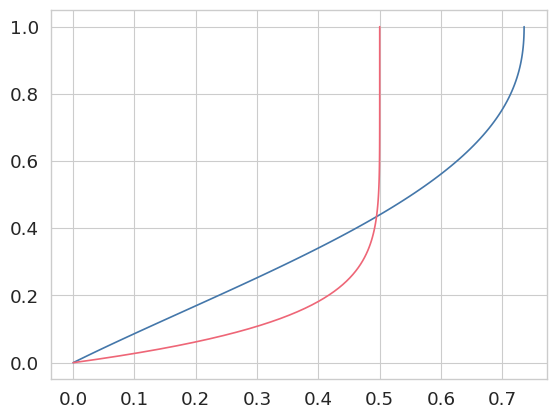

In [4]:
import matplotlib.pyplot as plt

U_b = testbasis.reconstruct_velocity_profile(0.5*coefs, Z=Z)
U_a = 0.5 * U(Z)

plt.plot(U_b, Z)
plt.plot(U_a, Z)
print(coefs)
print(U_a.mean())
print(U_a.mean())
inflow_profile_coefs = coefs

In [5]:

f_h = lambda t: 0.2 * cos(2 * 3.14 * t * 5.) + 1.
u_mean = 0.5

inflow_dict = {
    # 0: lambda t, x, dx, q, qaux, p, n: f_h(t),
    0: lambda t, x, dx, q, qaux, p, n: q[0],
    # 1: lambda t, x, dx, q, qaux, p, n: f_h(t) * u_mean * inflow_profile_coefs[0]
    1: lambda t, x, dx, q, qaux, p, n: q[0] * u_mean * inflow_profile_coefs[0]

    # 1: lambda t, x, dx, q, qaux, p, n: q[1]
}
# inflow_dict.update({1 + i: lambda t, x, dx, q, qaux, p, n: f_h(t) * u_mean * inflow_profile_coefs[1+i] for i in range(level)})
inflow_dict.update({1 + i: lambda t, x, dx, q, qaux, p, n: q[0] * u_mean * inflow_profile_coefs[1+i] for i in range(level)})
# inflow_dict.update({1 + i: lambda t, x, dx, q, qaux, p, n: q[1+i] for i in range(level)})

outflow_dict = {
    0: lambda t, x, dx, q, qaux, p, n: f_h(t),
    # 1: lambda t, x, dx, q, qaux, p, n: f_h(t) * u_mean * inflow_profile_coefs[0]
    1: lambda t, x, dx, q, qaux, p, n: q[1]
}
outflow_dict.update({1 + i: lambda t, x, dx, q, qaux, p, n: q[i+1] for i in range(level)})

bcs = BC.BoundaryConditions(
    [
        BC.Lambda(physical_tag="left", prescribe_fields=inflow_dict),
        BC.Lambda(physical_tag="right", prescribe_fields=outflow_dict),
        # BC.Extrapolation(physical_tag="right"),
    ]
)


def custom_ic(x):
    Q = np.zeros(2 + level, dtype=float)
    Q[0] = 1.
    return Q


ic = IC.UserFunction(custom_ic)

class MyModel(ShallowMoments):
    def source(self):   
        out = Matrix([0 for i in range(self.n_variables)])
        # out += self.chezy()
        # out += self.slip()
        # out += self.slip_mod()
        # out += self.newtonian_turbulent_algebraic()
        # out += self.regress_against_power_profile()
        return out

model = MyModel(
    level = level,
    boundary_conditions=bcs,
    parameters=Zstruct(C=30., lamda=0.001, rho=1000., kappa=0.41, l_bl=0.01, l_turb=0.05, nu=1e-6, c_slipmod=1., r_pp=1.),
    basisfunctions=basis
)

main_dir = os.getenv("ZOOMY_DIR")
# mesh = petscMesh.Mesh.from_gmsh(
#     os.path.join(main_dir, "meshes/channel_junction/mesh_2d_coarse.msh")
#     # os.path.join(main_dir, "meshes/channel_junction/mesh_2d_fine.msh")
# )

mesh = petscMesh.Mesh.create_1d([0.0, 10.0], 400)





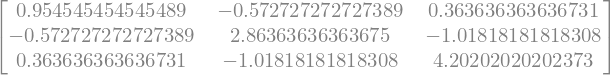

In [9]:
model.basismatrices.Minv

In [6]:
class SMESolver(HyperbolicSolver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        dudx = compute_derivatives(Q[1] / Q[0], mesh, derivatives_multi_index=[[0, 0]])[
            :, 0
        ]
        # dvdy = compute_derivatives(
        #     Q[1 + offset] / Q[0], mesh, derivatives_multi_index=[[0, 1]]
        # )[:, 0]
        Qaux = Qaux.at[0].set(dudx)
        # Qaux = Qaux.at[1].set(dvdy)
        return Qaux


solver = SMESolver(settings=settings, time_end=10.0, compute_dt=timestepping.adaptive(CFL=0.5))

## Solver

In [7]:
Qnew, Qaux = solver.solve(mesh, model)


2025-09-23 16:18:08.329 | INFO     | library.fvm.solver:log_callback_execution_time:56 - Finished simulation with in 40.083 seconds


## Visualization

In [8]:
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.name}.h5"))
postprocessing.vtk_interpolate_3d(model, settings, Nz=50, filename='out_3d')

2025-09-23 16:18:19.907 | INFO     | library.postprocessing.postprocessing:vtk_interpolate_3d:62 - Converted snapshot 0/2
2025-09-23 16:18:19.920 | INFO     | library.postprocessing.postprocessing:vtk_interpolate_3d:62 - Converted snapshot 1/2
2025-09-23 16:18:19.945 | INFO     | library.postprocessing.postprocessing:vtk_interpolate_3d:65 - Output is written to: /home/ingo/Git/Zoomy/outputs/junction_2/out_3d.h5/out_3d.*.vtk
